In [8]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Deep learning imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout

# Building a neural network

In [9]:
#Generating random data
input_shape = (784)
X_test = np.random.random((1000, 784))
y_test = np.random.randint(2, size=(1000, 1))
X_train = np.random.random((600, 784))
y_train = np.random.randint(2, size=(600, 1))

In [10]:
def build_model():
  #Instantiate the model
  model = Sequential()
  #Hidden layer
  model.add(Dense(128, input_dim =input_shape, activation='relu'))
  #output layer
  model.add(Dense(1, activation = 'sigmoid')) # using the linear activation function

  # Compile
  model.compile(loss = 'bce', optimizer = 'adam',
                metrics=['accuracy',
                         tf.keras.metrics.Recall(name='recall'),
                         tf.keras.metrics.Precision(name='precision'),
                        ])
  return model

In [11]:
bin_model = build_model()

# Get model summary
bin_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 100609 (393.00 KB)
Trainable params: 100609 (393.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [13]:
history = bin_model.fit(X_train, y_train,
                        validation_split = .2,
                        epochs=50,
                        verbose=0, callbacks = [early_stop])

In [14]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):

    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]

    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)

    # For each metric
    for i, metric_name in enumerate(metrics):

        # Get the axis for the current metric
        ax = axes[i]

        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch

        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)

        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)

        # Final subplot adjustments
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

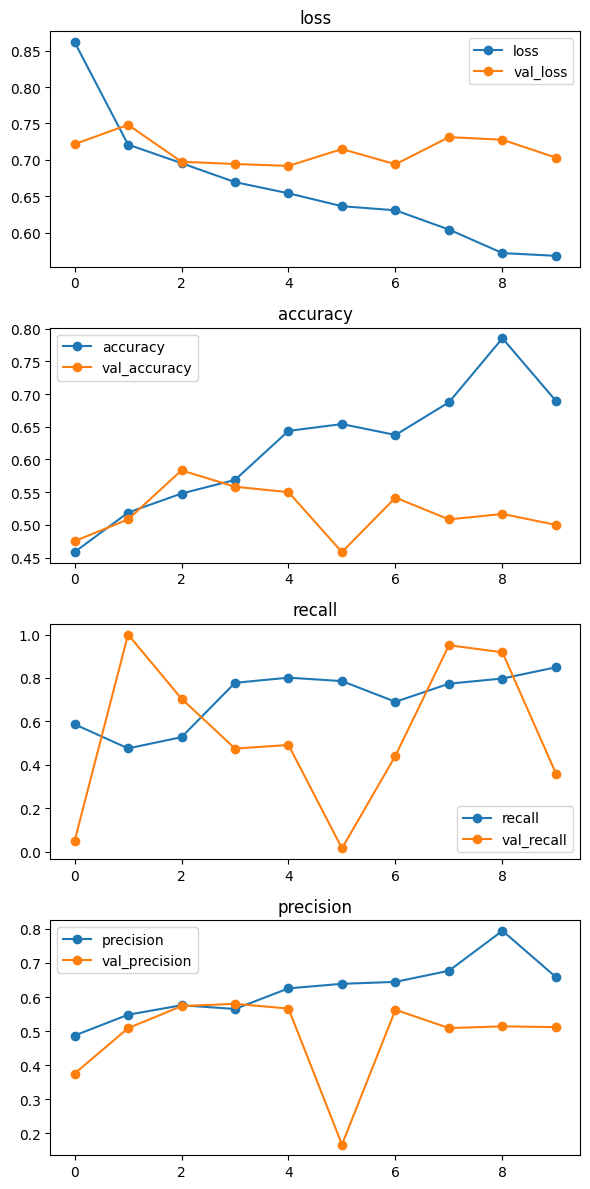

In [15]:
# plot learning
plot_history(history);

## Evaluating the model

In [16]:
## make predictions
y_pred_test = bin_model.predict(X_test)
y_pred_test[:5]

32/32 [==============================] - 0s 3ms/step


array([[0.65505975],
       [0.3643886 ],
       [0.5690599 ],
       [0.4090426 ],
       [0.40829235]], dtype=float32)

In [17]:
# round the predictions
y_pred_test = np.round(y_pred_test)
y_pred_test[:5]

array([[1.],
       [0.],
       [1.],
       [0.],
       [0.]], dtype=float32)

              precision    recall  f1-score   support

           0       0.48      0.61      0.54       494
           1       0.49      0.37      0.42       506

    accuracy                           0.49      1000
   macro avg       0.49      0.49      0.48      1000
weighted avg       0.49      0.49      0.48      1000



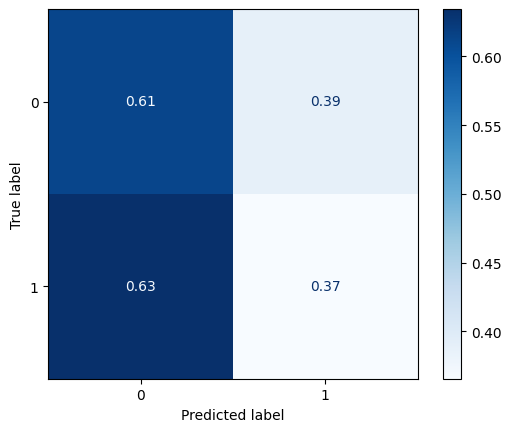

In [18]:
#Using a confusion matrix and a classification report
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
print(classification_report(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap='Blues',
                                       normalize='true');



## Tuning with the Keras tuner

In [3]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [4]:
from keras_tuner import HyperParameters as hp
import keras_tuner as kt

In [19]:
# Define the model building function for Keras Tuner
def build_model(hp):
  # Instantiate Model
    model = Sequential()

    # First hidden layer
    model.add(Dense(
        units=hp.Int('units_1', min_value=32, max_value=512, step=32),
        input_dim=input_shape,
        activation=hp.Choice('activation_1', ['relu', 'tanh', 'sigmoid'])
    ))

    # Second hidden layer
    model.add(Dense(
        units=hp.Int('units_2', min_value=32, max_value=512, step=32),
        activation=hp.Choice('activation_2', ['relu', 'tanh', 'sigmoid'])
    ))
    # Dropout layer
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(
        optimizer=hp.Choice('optimizer', ['rmsprop', 'nadam', 'adam']),
        loss='bce',
        metrics=['accuracy',
                 tf.keras.metrics.Recall(name='recall'),
                 tf.keras.metrics.Precision(name='precision')]
    )

    return model

In [6]:
# Make a folder to store results of hyperparameter tuning
import os
Myfolder = 'KerasTuning/'
os.makedirs(Myfolder, exist_ok=True)

In [20]:
# Define tuner object
tuner = kt.Hyperband(build_model,
                     objective=kt.Objective('val_precision', direction='max'),
                     max_epochs=5,
                     directory=Myfolder,
                     overwrite = True,
                     seed = 42,
                     project_name='My_Hyperparameter_Tuning')


In [22]:
# Run the tuner
epochs = 100
tuner.search(X_train, y_train,  epochs=epochs,
             validation_data = (X_test, y_test), callbacks = [early_stop])

Trial 10 Complete [00h 00m 03s]
val_precision: 0.5059999823570251

Best val_precision So Far: 0.6666666865348816
Total elapsed time: 00h 00m 41s


In [23]:
# Obtain best hyperparameter values
best_hps=tuner.get_best_hyperparameters()[0]
best_hps.values

{'units_1': 288,
 'activation_1': 'relu',
 'units_2': 256,
 'activation_2': 'relu',
 'dropout': 0.4,
 'optimizer': 'nadam',
 'tuner/epochs': 5,
 'tuner/initial_epoch': 2,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0001'}

In [24]:
# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
results = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")
print(f"Test Recall: {results[2]}")
print(f"Test Precision: {results[3]}")

32/32 [==============================] - 1s 5ms/step - loss: 0.7425 - accuracy: 0.4950 - recall: 0.0040 - precision: 0.6667
Test Loss: 0.7424818873405457
Test Accuracy: 0.4950000047683716
Test Recall: 0.003952569328248501
Test Precision: 0.6666666865348816
